# Passing Heatmaps

- Heatmaps are simply 2D, spatial histograms - hotter squares = more passes (or whatever metric you choose).
- Remember to normalise them over the period of time you are looking at e.g. the no of games if looking across multiple games, 90 minutes if looking at 1 game etc.


## Setup

In [3]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen
import pandas as pd

parser = Sbopen()

## Data

In [10]:
df_match = parser.match(competition_id=72, season_id=30)
team = "England Women's"
match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].to_list()
no_games = len(match_ids)
no_games

7

## Get Dangerous Passes

In [13]:
danger_passes = pd.DataFrame()

for id in match_ids:
    df = parser.event(id)[0]

    for period in [1,2]:
        mask_pass = (df["team_name"] == team) & (df["type_name"] == "Pass") & (df["outcome_name"].isnull()) & (df["period"] == period) & (df["sub_type_name"].isnull())
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]

        pass_times = passes["minute"]*60+passes["second"]

        mask_shot = (df["team_name"] == team) & (df["type_name"] == "Shot") & (df["period"] == period)
        shots = df.loc[mask_shot, ["minute", "second"]]

        shot_times = shots["minute"]*60 + shots["second"]
        shot_window = 15
        shot_start = shot_times - shot_window
        # Prevent negative shot start times
        shot_start = shot_start.apply(lambda i: i if i > 0 else (period-1)*45)

        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        danger_passes_period = passes.loc[pass_to_shot]
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index=True)

danger_passes

,x,y,end_x,end_y,minute,second,player_name
0,114.6,16.4,111.3,7.1,22,40,Ellen White
1,32.9,70.0,42.0,68.5,30,26,Stephanie Houghton
2,41.7,71.0,45.1,76.5,30,27,Jill Scott
3,53.9,76.2,67.0,62.0,30,30,Nikita Parris
4,70.4,54.9,85.1,66.2,30,32,Jill Scott
...,...,...,...,...,...,...,...
171,101.6,44.4,98.9,27.5,85,12,Francesca Kirby
172,98.9,27.5,107.1,54.8,85,14,Rachel Daly
173,76.0,70.2,78.4,64.0,95,38,Francesca Kirby
174,78.4,64.0,70.9,66.9,95,39,Jill Scott


## Plot Dangerous Pass Locations

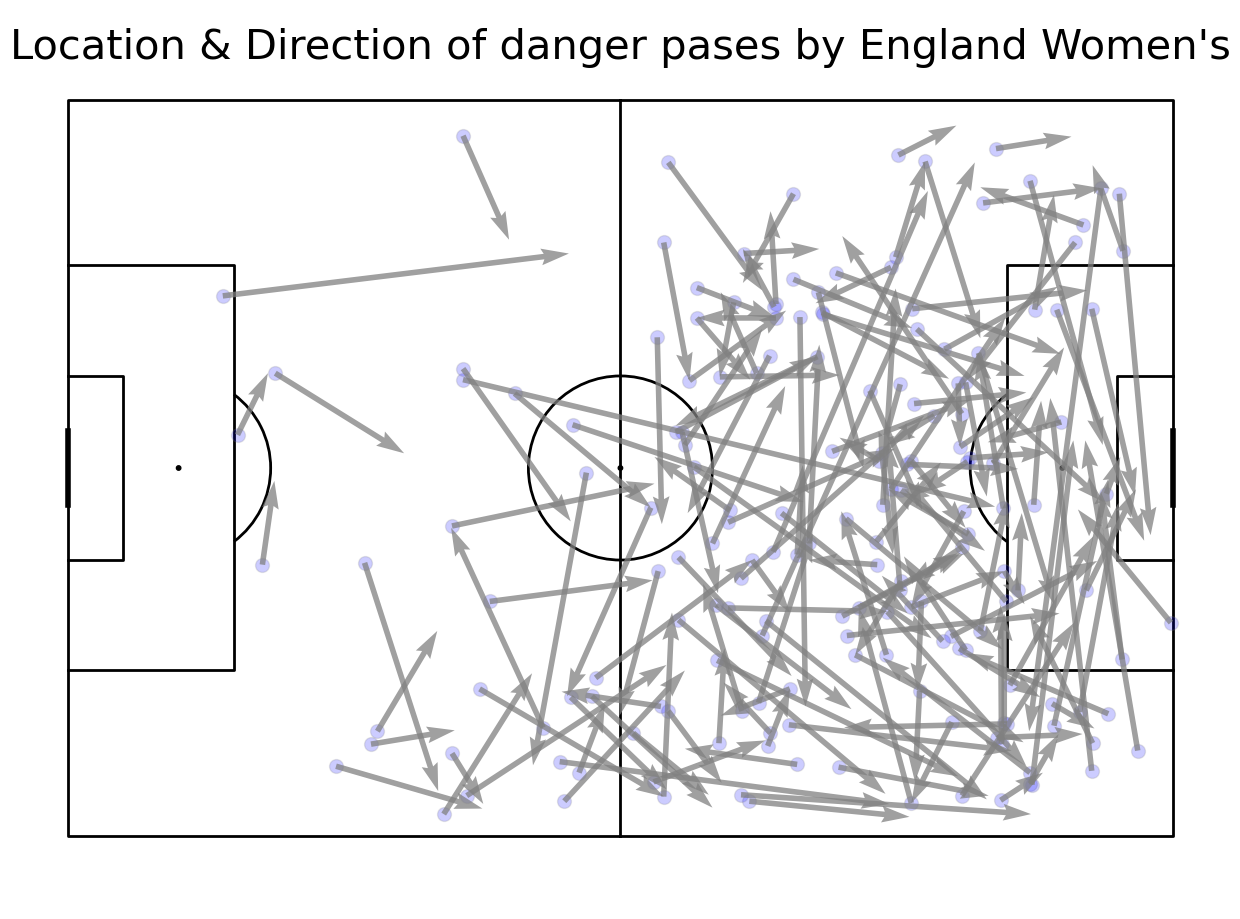

In [20]:
pitch = Pitch(line_color="black")
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

pitch.scatter(danger_passes["x"], danger_passes["y"], s=100, color="blue", edgecolors="grey", linewidth=1, alpha=0.2, ax=ax["pitch"])
pitch.arrows(danger_passes["x"], danger_passes["y"], danger_passes["end_x"], danger_passes["end_y"], color="grey", alpha=0.75, ax=ax["pitch"])
fig.suptitle(f"Location & Direction of danger pases by {team}", fontsize=30)
plt.show();

### Make the Heatmap
In really simple terms this is a normalised (per game) 2D histogram.

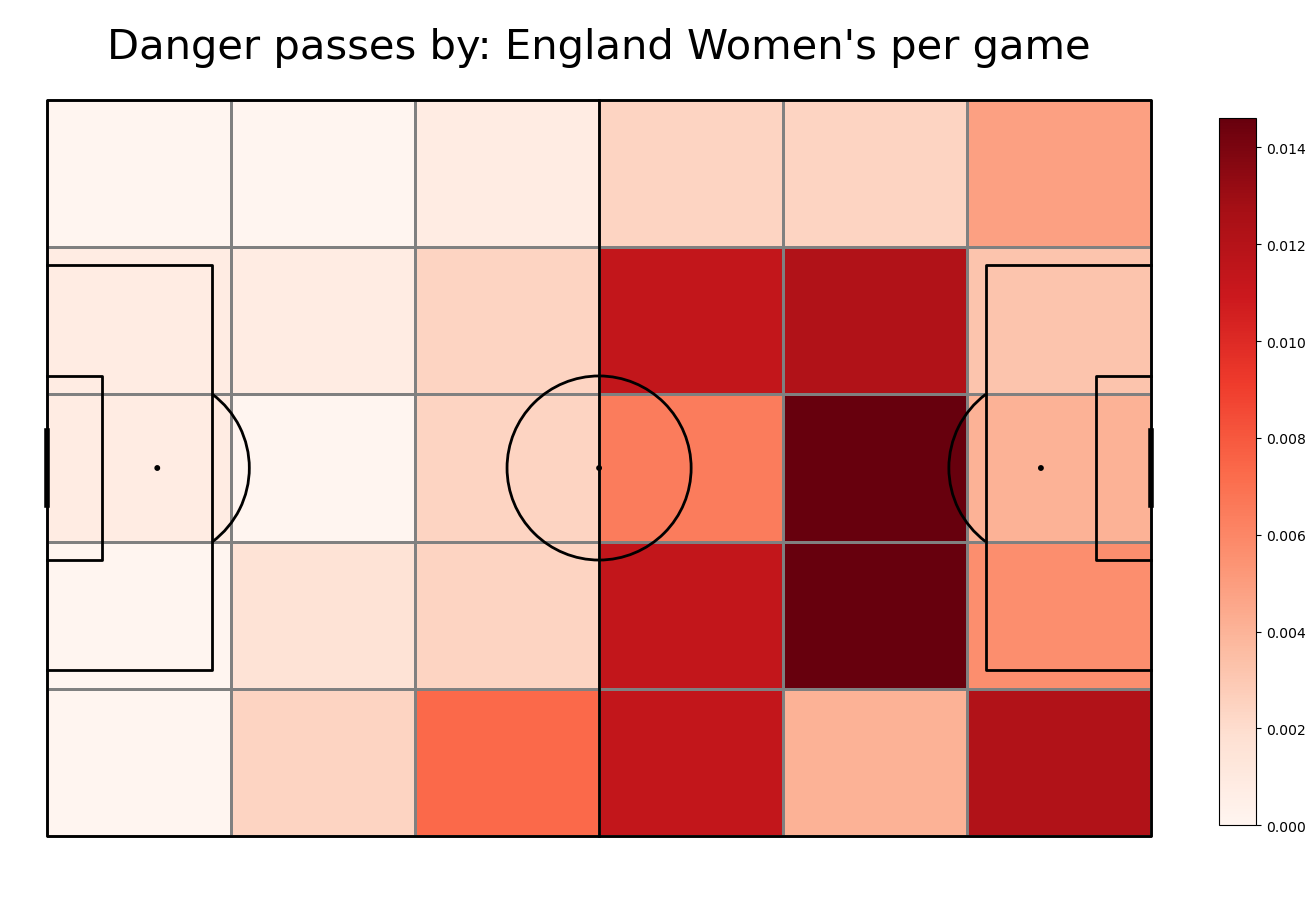

In [24]:
pitch = Pitch(line_zorder=2, line_color="black")
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic = pitch.bin_statistic(danger_passes["x"], danger_passes["y"], statistic="count", bins=(6,5), normalize=True)
bin_statistic["statistic"] = bin_statistic["statistic"] / no_games

pcm = pitch.heatmap(bin_statistic, cmap="Reds", edgecolor="grey", ax=ax["pitch"])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle(f"Danger passes by: {team} per game", fontsize=30)
plt.show()

### Most Involved Players

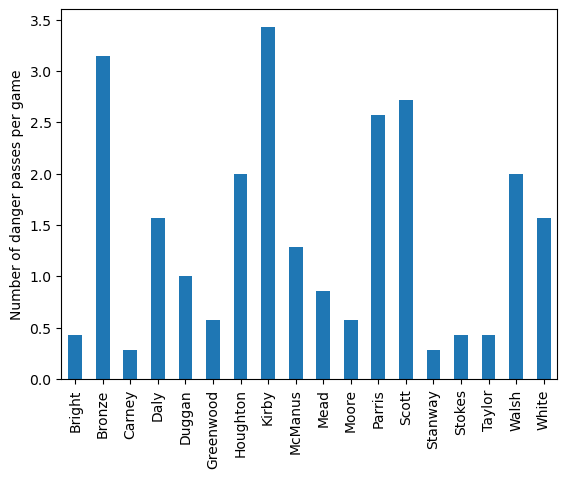

In [25]:
danger_passes["player_name"] = danger_passes["player_name"].apply(lambda x: str(x).split()[-1])
pass_count = danger_passes.groupby(["player_name"]).x.count() / no_games

ax = pass_count.plot.bar(pass_count)
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show();

### Challenges
#### 1. Only high xG (>0.07) included.
- Column for xG is `shot_statsbomb_xg`

In [37]:
danger_passes_high_xg = pd.DataFrame()

for id in match_ids:
    df = parser.event(id)[0]

    for period in [1,2]:
        mask_pass = (df["team_name"] == team) & (df["type_name"] == "Pass") & (df["outcome_name"].isnull()) & (df["period"] == period) & (df["sub_type_name"].isnull())
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]

        pass_times = passes["minute"]*60+passes["second"]

        mask_shot = (df["team_name"] == team) & (df["type_name"] == "Shot") & (df["shot_statsbomb_xg"] > 0.07) & (df["period"] == period)
        shots = df.loc[mask_shot, ["minute", "second"]]

        shot_times = shots["minute"]*60 + shots["second"]
        shot_window = 15
        shot_start = shot_times - shot_window
        # Prevent negative shot start times
        shot_start = shot_start.apply(lambda i: i if i > 0 else (period-1)*45)

        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        danger_passes_period = passes.loc[pass_to_shot]
        danger_passes_high_xg = pd.concat([danger_passes_high_xg, danger_passes_period], ignore_index=True)

danger_passes_high_xg

,x,y,end_x,end_y,minute,second,player_name
0,32.9,70.0,42.0,68.5,30,26,Stephanie Houghton
1,41.7,71.0,45.1,76.5,30,27,Jill Scott
2,53.9,76.2,67.0,62.0,30,30,Nikita Parris
3,70.4,54.9,85.1,66.2,30,32,Jill Scott
4,21.1,50.5,22.4,41.4,50,40,Lucy Bronze
...,...,...,...,...,...,...,...
93,99.1,57.7,102.0,43.4,91,4,Rachel Daly
94,79.2,72.2,67.0,70.5,18,29,Nikita Parris
95,70.7,69.9,71.3,59.6,18,31,Lucy Bronze
96,75.4,58.2,98.5,6.8,18,34,Keira Walsh


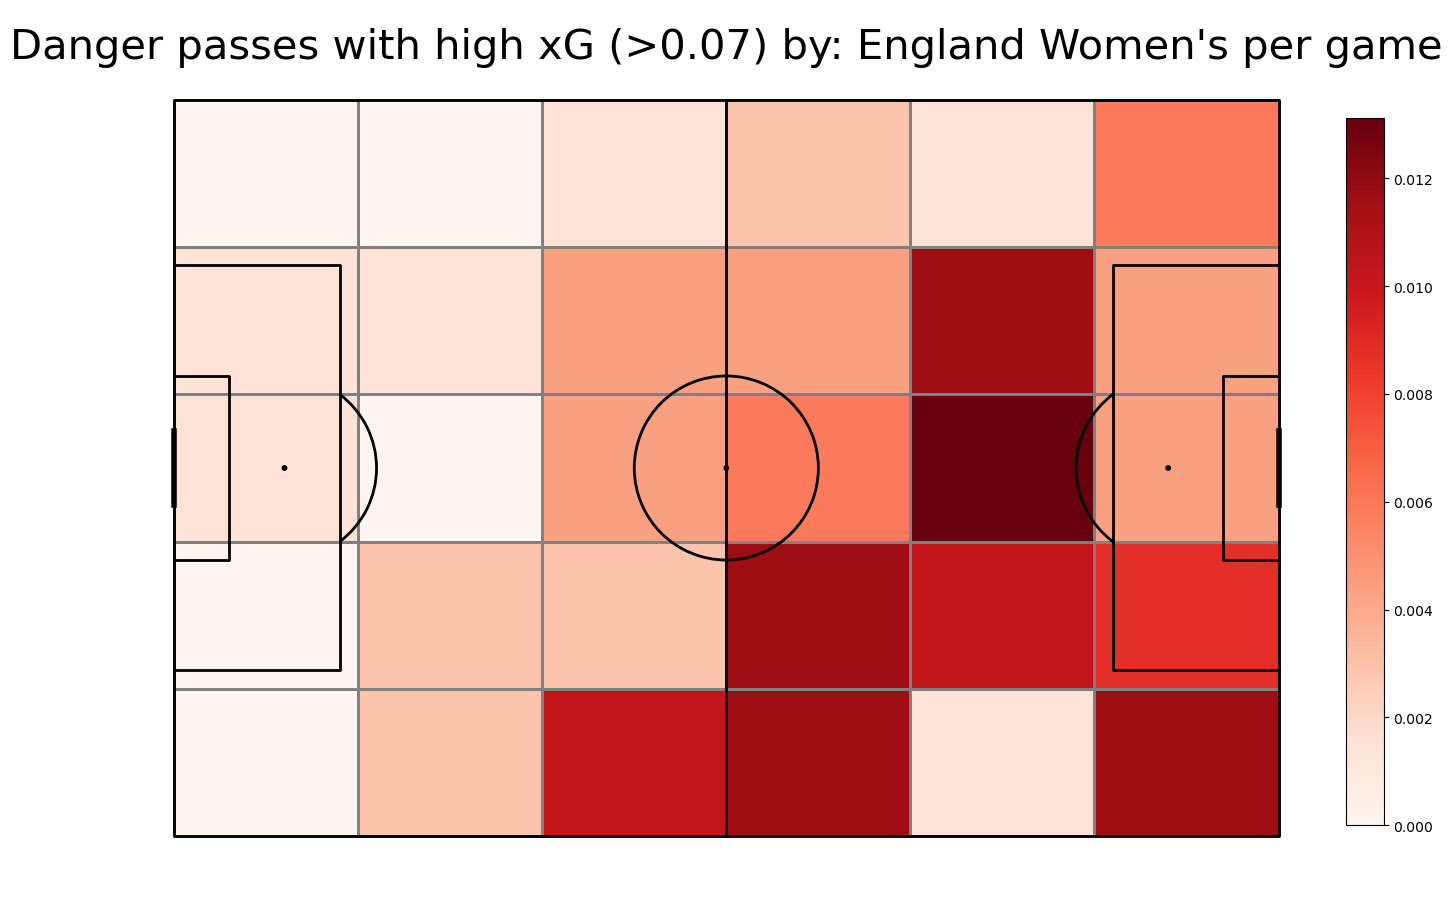

In [39]:
pitch = Pitch(line_zorder=2, line_color="black")
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic = pitch.bin_statistic(danger_passes_high_xg["x"], danger_passes_high_xg["y"], statistic="count", bins=(6,5), normalize=True)
bin_statistic["statistic"] = bin_statistic["statistic"] / no_games

pcm = pitch.heatmap(bin_statistic, cmap="Reds", edgecolor="grey", ax=ax["pitch"])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle(f"Danger passes with high xG (>0.07) by: {team} per game", fontsize=30)
plt.show()

#### 2. Heatmap for Sweden's Player involved in the most dangerous passes!

In [40]:
df_match = parser.match(competition_id=72, season_id=30)
team = "Sweden Women's"
match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].to_list()
no_games = len(match_ids)
no_games

7

In [49]:
danger_passes_sweden = pd.DataFrame()

for id in match_ids:
    df = parser.event(id)[0]

    for period in [1,2]:
        mask_pass = (df["team_name"] == team) & (df["type_name"] == "Pass") & (df["outcome_name"].isnull()) & (df["period"] == period) & (df["sub_type_name"].isnull())
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]

        pass_times = passes["minute"]*60+passes["second"]

        mask_shot = (df["team_name"] == team) & (df["type_name"] == "Shot") & (df["period"] == period)
        shots = df.loc[mask_shot, ["minute", "second"]]

        shot_times = shots["minute"]*60 + shots["second"]
        shot_window = 15
        shot_start = shot_times - shot_window
        # Prevent negative shot start times
        shot_start = shot_start.apply(lambda i: i if i > 0 else (period-1)*45)

        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        danger_passes_period = passes.loc[pass_to_shot]
        danger_passes_sweden = pd.concat([danger_passes_sweden, danger_passes_period], ignore_index=True)

danger_passes_sweden

,x,y,end_x,end_y,minute,second,player_name
0,68.0,51.1,61.4,40.1,17,41,Nilla Fischer
1,61.4,36.6,65.1,24.3,17,43,Linda Brigitta Sembrant
2,67.1,23.3,77.6,6.4,17,45,Sara Caroline Seger
3,77.0,6.4,109.8,8.5,17,47,Magdalena Lilly Eriksson
4,116.5,22.4,109.1,46.2,17,53,Emma Stina Blackstenius
...,...,...,...,...,...,...,...
164,93.4,47.4,96.8,56.3,92,23,Olivia Alma Charlotta Schough
165,96.8,56.3,105.7,69.4,92,25,Kosovare Asllani
166,107.4,69.1,106.4,44.6,92,26,Elin Ingrid Johanna Rubensson
167,93.8,40.8,107.9,51.5,12,38,Eva Sofia Jakobsson


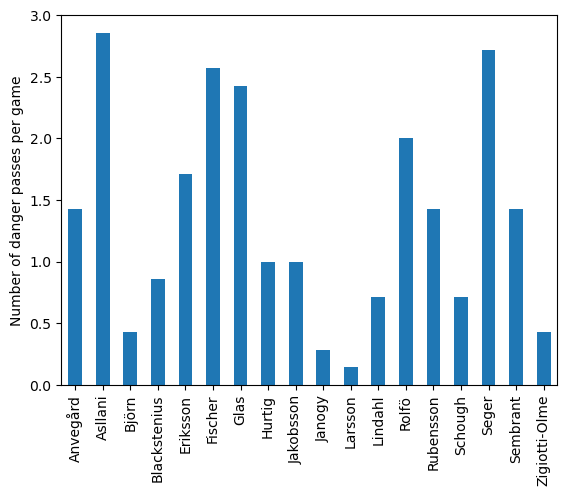

In [50]:
danger_passes_sweden["player_name"] = danger_passes_sweden["player_name"].apply(lambda x: str(x).split()[-1])
pass_count = danger_passes_sweden.groupby(["player_name"]).x.count() / no_games

ax = pass_count.plot.bar(pass_count)
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show();

Kosovare Asllani is the Sweedish player who has been involved in the most dangerous passes!

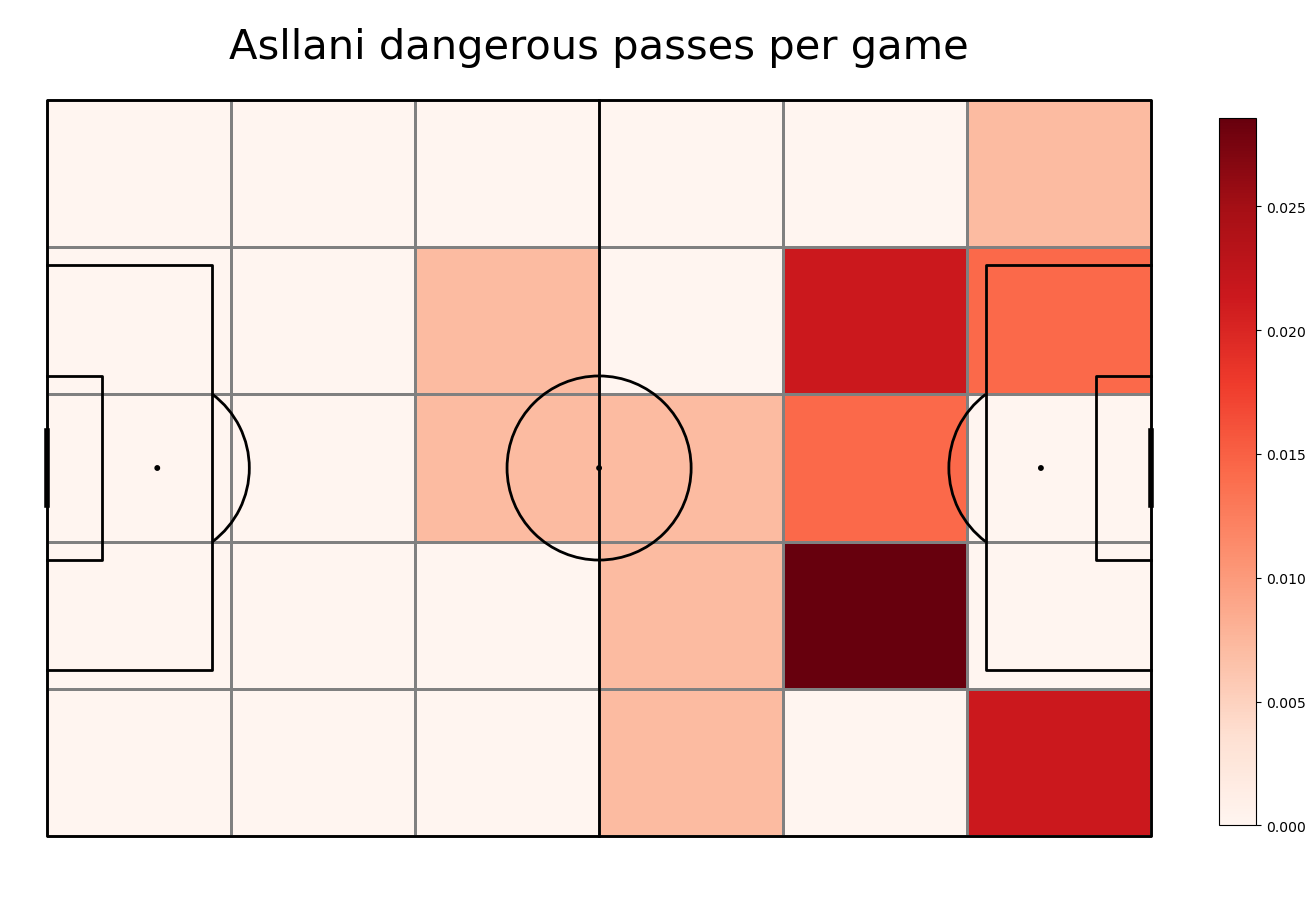

In [52]:
asllani_passes = danger_passes_sweden[danger_passes_sweden["player_name"] == "Asllani"]

pitch = Pitch(line_zorder=2, line_color="black")
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic = pitch.bin_statistic(asllani_passes["x"], asllani_passes["y"], statistic="count", bins=(6,5), normalize=True)
bin_statistic["statistic"] = bin_statistic["statistic"] / no_games

pcm = pitch.heatmap(bin_statistic, cmap="Reds", edgecolor="grey", ax=ax["pitch"])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle(f"Asllani dangerous passes per game", fontsize=30)
plt.show()